<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-8i1_yu6g
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-8i1_yu6g
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 174 kB 65.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |██████

In [2]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_conservative import StockTradingEnvCon
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot2 import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [5]:
# from config.py TRAIN_END_DATE is a string
# config.TRAIN_END_DATE
# df2=TushareDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [6]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [7]:
# print(config_tickers.DOW_30_TICKER)

In [8]:
df=pd.read_csv('./1.csv')
df.shape

(94360, 9)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day
0,0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,1,2008-12-31,57.110001,58.220001,57.060001,43.924454,6287200,AMGN,2
2,2,2008-12-31,17.969999,18.750000,17.910000,14.908465,9625600,AXP,2
3,3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2
4,4,2008-12-31,43.700001,45.099998,43.700001,30.628819,6277400,CAT,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [10]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.INDICATORS,
#                     use_vix=True,
#                     use_turbulence=True,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [11]:
# list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

# processed_full = processed_full.fillna(0)

In [12]:
processed_full=pd.read_csv('./2.csv')
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.606277,607541200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,2.606277,2.606277,40.0,0.0
1,1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.924454,6287200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.924454,43.924454,40.0,0.0
2,2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.908465,9625600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,14.908465,14.908465,40.0,0.0
3,3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005894,5443100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,32.005894,32.005894,40.0,0.0
4,4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.628819,6277400.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,30.628819,30.628819,40.0,0.0
5,5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.787783,37513700.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,11.787783,11.787783,40.0,0.0
7,7,2008-12-31,CVX,72.900002,74.629997,72.900002,43.314438,9964300.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.314438,43.314438,40.0,0.0
8,8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538342,9012100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,19.538342,19.538342,40.0,0.0
9,9,2008-12-31,GS,82.239998,86.150002,81.120003,69.224182,14894100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,69.224182,69.224182,40.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [13]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [14]:
train.tail()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,121795,2020-06-30,UNH,288.570007,296.450012,287.660004,287.776794,2932900.0,1.0,-0.019475,303.925869,271.251255,52.413046,-25.838431,1.846804,288.020689,281.001438,30.43,12.918751
2892,121796,2020-06-30,V,191.490005,193.750000,190.160004,190.737244,9040100.0,1.0,1.048786,198.750528,185.041391,53.021033,-51.550760,2.013358,191.485037,181.677683,30.43,12.918751
2892,121797,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376743,17414800.0,1.0,-0.437111,53.918425,48.729324,48.097044,-51.018262,8.508886,51.012123,51.464679,30.43,12.918751
2892,121798,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035732,4782100.0,1.0,-0.083986,42.609305,36.487095,48.830181,-14.508130,1.500723,39.135190,38.935129,30.43,12.918751
2892,121799,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121765,6836400.0,1.0,-0.886569,119.473758,113.510454,48.159665,-69.938795,3.847271,117.787627,119.723273,30.43,12.918751


In [15]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [16]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [17]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [18]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

e_train_gym_conservative = StockTradingEnvCon(df = train, **env_kwargs)

## Environment for Training



In [19]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train_con, _ = e_train_gym_conservative.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [20]:
agent = DRLAgent(env = env_train)
agent_con = DRLAgent(env = env_train_con)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [62]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -1.41      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -72.8      |
|    reward             | 0.19451597 |
|    std                | 1          |
|    value_loss         | 3.68       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 68         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -0.115     |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 1500      |
|    time_elapsed       | 108       |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -39.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 169       |
|    reward             | 4.8591986 |
|    std                | 1.01      |
|    value_loss         | 21.7      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 1600       |
|    time_elapsed       | 115        |
|    total_timesteps    | 8000       |
| train/                |            |
|    entropy_loss       | -40        |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 2900      |
|    time_elapsed       | 209       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -40.1     |
|    explained_variance | 0.88      |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -116      |
|    reward             | 2.3091433 |
|    std                | 1.01      |
|    value_loss         | 9.5       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 3000       |
|    time_elapsed       | 216        |
|    total_timesteps    | 15000      |
| train/                |            |
|    entropy_loss       | -40.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 4300      |
|    time_elapsed       | 309       |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -40.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4299      |
|    policy_loss        | -64       |
|    reward             | 3.9822705 |
|    std                | 1.02      |
|    value_loss         | 3.59      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 4400       |
|    time_elapsed       | 317        |
|    total_timesteps    | 22000      |
| train/                |            |
|    entropy_loss       | -40.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 5600        |
|    time_elapsed       | 403         |
|    total_timesteps    | 28000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 5599        |
|    policy_loss        | -46.9       |
|    reward             | -0.06746031 |
|    std                | 1.02        |
|    value_loss         | 3.12        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 5700       |
|    time_elapsed       | 411        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | 0.00117    |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7000       |
|    time_elapsed       | 504        |
|    total_timesteps    | 35000      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 6999       |
|    policy_loss        | 72.3       |
|    reward             | 0.22214015 |
|    std                | 1.03       |
|    value_loss         | 3.11       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7100       |
|    time_elapsed       | 511        |
|    total_timesteps    | 35500      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 0          |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 8400        |
|    time_elapsed       | 605         |
|    total_timesteps    | 42000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 8399        |
|    policy_loss        | -214        |
|    reward             | -0.94865924 |
|    std                | 1.03        |
|    value_loss         | 30.5        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 8500      |
|    time_elapsed       | 613       |
|    total_timesteps    | 42500     |
| train/                |           |
|    entropy_loss       | -40.4     |
|    explained_variance | 0         |
|    learning_rate

------------------------------------
| time/                 |          |
|    fps                | 69       |
|    iterations         | 9800     |
|    time_elapsed       | 706      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -40.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 177      |
|    reward             | 8.957433 |
|    std                | 1.04     |
|    value_loss         | 58.6     |
------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 9900        |
|    time_elapsed       | 714         |
|    total_timesteps    | 49500       |
| train/                |             |
|    entropy_loss       | -40.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_u

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [31]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [32]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name="1",
                             total_timesteps=3000000)

Logging to ppo/1_1
------------------------------------
| time/              |             |
|    fps             | 124         |
|    iterations      | 1           |
|    time_elapsed    | 16          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.021770535 |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 2           |
|    time_elapsed         | 34          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016675381 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.00593    |
|    learning_rate        | 0.00025     |
|    loss                 | 6.58        |
|    n_updates            | 10          |
|    policy_gradie

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 12          |
|    time_elapsed         | 217         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.025821913 |
|    clip_fraction        | 0.306       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.6       |
|    explained_variance   | -0.0203     |
|    learning_rate        | 0.00025     |
|    loss                 | 10.5        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0163     |
|    reward               | 0.07737823  |
|    std                  | 1.02        |
|    value_loss           | 16.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 13    

day: 2892, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 3368339.43
total_reward: 2368339.43
total_cost: 323580.50
total_trades: 78402
Sharpe: 0.695
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 22          |
|    time_elapsed         | 403         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.020597888 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42         |
|    explained_variance   | 0.00184     |
|    learning_rate        | 0.00025     |
|    loss                 | 11.4        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0153     |
|    reward               | 2.116288    |
|    std                  | 1.03        |
|    value_loss           | 34.4        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 32          |
|    time_elapsed         | 586         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.037518755 |
|    clip_fraction        | 0.324       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.5       |
|    explained_variance   | -0.0236     |
|    learning_rate        | 0.00025     |
|    loss                 | 16.8        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00537    |
|    reward               | -0.6000197  |
|    std                  | 1.05        |
|    value_loss           | 30.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 33    

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 42         |
|    time_elapsed         | 770        |
|    total_timesteps      | 86016      |
| train/                  |            |
|    approx_kl            | 0.03518012 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.3      |
|    explained_variance   | -0.00032   |
|    learning_rate        | 0.00025    |
|    loss                 | 34.5       |
|    n_updates            | 410        |
|    policy_gradient_loss | -0.00434   |
|    reward               | -0.5073143 |
|    std                  | 1.08       |
|    value_loss           | 54.3       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 43          |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 52          |
|    time_elapsed         | 955         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.030218782 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.8       |
|    explained_variance   | 0.0114      |
|    learning_rate        | 0.00025     |
|    loss                 | 59.4        |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.000609   |
|    reward               | -1.248837   |
|    std                  | 1.1         |
|    value_loss           | 75.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 53    

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 62          |
|    time_elapsed         | 1140        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.032515235 |
|    clip_fraction        | 0.279       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.2       |
|    explained_variance   | 0.0164      |
|    learning_rate        | 0.00025     |
|    loss                 | 104         |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.0061     |
|    reward               | 5.309159    |
|    std                  | 1.11        |
|    value_loss           | 212         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 63    

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 72          |
|    time_elapsed         | 1334        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.024974383 |
|    clip_fraction        | 0.269       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.8       |
|    explained_variance   | 0.115       |
|    learning_rate        | 0.00025     |
|    loss                 | 78.3        |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.00621    |
|    reward               | -27.624176  |
|    std                  | 1.14        |
|    value_loss           | 252         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 73    

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 82          |
|    time_elapsed         | 1522        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.029730117 |
|    clip_fraction        | 0.269       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.2       |
|    explained_variance   | 0.211       |
|    learning_rate        | 0.00025     |
|    loss                 | 46.4        |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.00655    |
|    reward               | -0.9988302  |
|    std                  | 1.15        |
|    value_loss           | 134         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 83    

day: 2892, episode: 90
begin_total_asset: 1000000.00
end_total_asset: 4444616.00
total_reward: 3444616.00
total_cost: 215889.48
total_trades: 68091
Sharpe: 0.816
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 92          |
|    time_elapsed         | 1714        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.013762552 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.4       |
|    explained_variance   | 0.0881      |
|    learning_rate        | 0.00025     |
|    loss                 | 31.1        |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.00418    |
|    reward               | -1.9625988  |
|    std                  | 1.16        |
|    value_loss           | 85.4        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 102         |
|    time_elapsed         | 1906        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.028208815 |
|    clip_fraction        | 0.28        |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.9       |
|    explained_variance   | 0.172       |
|    learning_rate        | 0.00025     |
|    loss                 | 51.1        |
|    n_updates            | 1010        |
|    policy_gradient_loss | 0.00558     |
|    reward               | -1.6960285  |
|    std                  | 1.18        |
|    value_loss           | 106         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 103   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 112         |
|    time_elapsed         | 2093        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.034454226 |
|    clip_fraction        | 0.366       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.4       |
|    explained_variance   | 0.0447      |
|    learning_rate        | 0.00025     |
|    loss                 | 20.8        |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.0104     |
|    reward               | -2.8606803  |
|    std                  | 1.2         |
|    value_loss           | 34.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 113   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 122         |
|    time_elapsed         | 2282        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.026874889 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.7       |
|    explained_variance   | 0.0663      |
|    learning_rate        | 0.00025     |
|    loss                 | 28.5        |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.0123     |
|    reward               | 1.1695658   |
|    std                  | 1.21        |
|    value_loss           | 37          |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 109       |
|    iterations           | 123       |


-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 132         |
|    time_elapsed         | 2472        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.022990465 |
|    clip_fraction        | 0.299       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.4       |
|    explained_variance   | -0.00287    |
|    learning_rate        | 0.00025     |
|    loss                 | 15.2        |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.00796    |
|    reward               | 1.9085146   |
|    std                  | 1.24        |
|    value_loss           | 27.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 133   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 142         |
|    time_elapsed         | 2657        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.034135416 |
|    clip_fraction        | 0.302       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.9       |
|    explained_variance   | -0.00617    |
|    learning_rate        | 0.00025     |
|    loss                 | 11.2        |
|    n_updates            | 1410        |
|    policy_gradient_loss | -0.000728   |
|    reward               | -1.742822   |
|    std                  | 1.26        |
|    value_loss           | 30.7        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 143      

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 152         |
|    time_elapsed         | 2844        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.042242467 |
|    clip_fraction        | 0.29        |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.3       |
|    explained_variance   | 0.0197      |
|    learning_rate        | 0.00025     |
|    loss                 | 18.1        |
|    n_updates            | 1510        |
|    policy_gradient_loss | -0.000349   |
|    reward               | -2.3885849  |
|    std                  | 1.28        |
|    value_loss           | 32.7        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 153      

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 162         |
|    time_elapsed         | 3033        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.029355118 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.7       |
|    explained_variance   | 0.02        |
|    learning_rate        | 0.00025     |
|    loss                 | 29.3        |
|    n_updates            | 1610        |
|    policy_gradient_loss | 0.00548     |
|    reward               | -0.40571308 |
|    std                  | 1.3         |
|    value_loss           | 55.1        |
-----------------------------------------
day: 2892, episode: 140
begin_total_asset: 1000000.00
end_total_asset: 3575552.56
total_reward: 2575552.56
total_cost: 316407.50
total_trades: 75459
Sharpe: 0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 172         |
|    time_elapsed         | 3221        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.012734976 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.1       |
|    explained_variance   | 0.26        |
|    learning_rate        | 0.00025     |
|    loss                 | 24.1        |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.00535    |
|    reward               | 0.8588058   |
|    std                  | 1.32        |
|    value_loss           | 39.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 173   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 182         |
|    time_elapsed         | 3407        |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.035993554 |
|    clip_fraction        | 0.402       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.5       |
|    explained_variance   | 0.0222      |
|    learning_rate        | 0.00025     |
|    loss                 | 59.2        |
|    n_updates            | 1810        |
|    policy_gradient_loss | -0.0017     |
|    reward               | -1.4716673  |
|    std                  | 1.34        |
|    value_loss           | 142         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 183   

----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 192        |
|    time_elapsed         | 3593       |
|    total_timesteps      | 393216     |
| train/                  |            |
|    approx_kl            | 0.0199944  |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -50.1      |
|    explained_variance   | 0.0407     |
|    learning_rate        | 0.00025    |
|    loss                 | 32.9       |
|    n_updates            | 1910       |
|    policy_gradient_loss | -0.0052    |
|    reward               | -4.5427675 |
|    std                  | 1.36       |
|    value_loss           | 81.3       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 193         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 202         |
|    time_elapsed         | 3779        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.032345608 |
|    clip_fraction        | 0.316       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.5       |
|    explained_variance   | 0.00381     |
|    learning_rate        | 0.00025     |
|    loss                 | 19.2        |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.00362    |
|    reward               | -4.4733596  |
|    std                  | 1.38        |
|    value_loss           | 50.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 203   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 212         |
|    time_elapsed         | 3966        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.0236976   |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -51         |
|    explained_variance   | 0.157       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.3        |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.00735    |
|    reward               | -0.19275466 |
|    std                  | 1.41        |
|    value_loss           | 39.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 213   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 222         |
|    time_elapsed         | 4157        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.015250949 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.4       |
|    explained_variance   | 0.174       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.7        |
|    n_updates            | 2210        |
|    policy_gradient_loss | -0.00593    |
|    reward               | -0.20103128 |
|    std                  | 1.43        |
|    value_loss           | 54.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 223   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 232         |
|    time_elapsed         | 4347        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.032742485 |
|    clip_fraction        | 0.277       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.7       |
|    explained_variance   | 0.24        |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 2310        |
|    policy_gradient_loss | -0.00952    |
|    reward               | -0.26191932 |
|    std                  | 1.44        |
|    value_loss           | 33.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 233   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 242         |
|    time_elapsed         | 4534        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.030230975 |
|    clip_fraction        | 0.316       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.1       |
|    explained_variance   | 0.44        |
|    learning_rate        | 0.00025     |
|    loss                 | 5.29        |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.0145     |
|    reward               | 0.9389994   |
|    std                  | 1.46        |
|    value_loss           | 19.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 243   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 252         |
|    time_elapsed         | 4723        |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.040094554 |
|    clip_fraction        | 0.314       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.7       |
|    explained_variance   | 0.197       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.44        |
|    n_updates            | 2510        |
|    policy_gradient_loss | -0.00761    |
|    reward               | 0.09476104  |
|    std                  | 1.49        |
|    value_loss           | 17.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 253   

day: 2892, episode: 210
begin_total_asset: 1000000.00
end_total_asset: 3860862.81
total_reward: 2860862.81
total_cost: 314751.64
total_trades: 74093
Sharpe: 0.733
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 262         |
|    time_elapsed         | 4912        |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.038828112 |
|    clip_fraction        | 0.363       |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.1       |
|    explained_variance   | 0.0892      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.34        |
|    n_updates            | 2610        |
|    policy_gradient_loss | -0.00505    |
|    reward               | 0.5520563   |
|    std                  | 1.51        |
|    value_loss           | 16.6        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 272         |
|    time_elapsed         | 5100        |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.036802948 |
|    clip_fraction        | 0.317       |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.6       |
|    explained_variance   | -0.0359     |
|    learning_rate        | 0.00025     |
|    loss                 | 8.43        |
|    n_updates            | 2710        |
|    policy_gradient_loss | -0.0026     |
|    reward               | 1.078453    |
|    std                  | 1.54        |
|    value_loss           | 22.2        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 273      

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 282         |
|    time_elapsed         | 5290        |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.030319719 |
|    clip_fraction        | 0.284       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.1       |
|    explained_variance   | 0.026       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.89        |
|    n_updates            | 2810        |
|    policy_gradient_loss | -0.00994    |
|    reward               | 0.71569437  |
|    std                  | 1.57        |
|    value_loss           | 20          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 283   

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 292         |
|    time_elapsed         | 5482        |
|    total_timesteps      | 598016      |
| train/                  |             |
|    approx_kl            | 0.018972535 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.4       |
|    explained_variance   | 0.0134      |
|    learning_rate        | 0.00025     |
|    loss                 | 76.1        |
|    n_updates            | 2910        |
|    policy_gradient_loss | -0.00367    |
|    reward               | 0.71743625  |
|    std                  | 1.58        |
|    value_loss           | 191         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 293   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 302         |
|    time_elapsed         | 5674        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.030097093 |
|    clip_fraction        | 0.316       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.8       |
|    explained_variance   | 0.0243      |
|    learning_rate        | 0.00025     |
|    loss                 | 26.5        |
|    n_updates            | 3010        |
|    policy_gradient_loss | 0.00185     |
|    reward               | -9.453128   |
|    std                  | 1.61        |
|    value_loss           | 84.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 303   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 312         |
|    time_elapsed         | 5865        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.027969645 |
|    clip_fraction        | 0.258       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.3       |
|    explained_variance   | 0.058       |
|    learning_rate        | 0.00025     |
|    loss                 | 89.4        |
|    n_updates            | 3110        |
|    policy_gradient_loss | -0.0116     |
|    reward               | -0.768669   |
|    std                  | 1.64        |
|    value_loss           | 112         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 313   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 322         |
|    time_elapsed         | 6056        |
|    total_timesteps      | 659456      |
| train/                  |             |
|    approx_kl            | 0.021962892 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.7       |
|    explained_variance   | 0.234       |
|    learning_rate        | 0.00025     |
|    loss                 | 26          |
|    n_updates            | 3210        |
|    policy_gradient_loss | -0.00354    |
|    reward               | 2.3639388   |
|    std                  | 1.66        |
|    value_loss           | 64.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 323   

day: 2892, episode: 260
begin_total_asset: 1000000.00
end_total_asset: 3047602.05
total_reward: 2047602.05
total_cost: 265525.30
total_trades: 70037
Sharpe: 0.596
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 332         |
|    time_elapsed         | 6247        |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.020978307 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.1       |
|    explained_variance   | 0.349       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.3        |
|    n_updates            | 3310        |
|    policy_gradient_loss | -0.00296    |
|    reward               | -0.66439843 |
|    std                  | 1.68        |
|    value_loss           | 56.2        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 342         |
|    time_elapsed         | 6435        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.027519114 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.6       |
|    explained_variance   | 0.0967      |
|    learning_rate        | 0.00025     |
|    loss                 | 19.9        |
|    n_updates            | 3410        |
|    policy_gradient_loss | -0.00581    |
|    reward               | 0.70230323  |
|    std                  | 1.71        |
|    value_loss           | 63.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 343   

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 352        |
|    time_elapsed         | 6620       |
|    total_timesteps      | 720896     |
| train/                  |            |
|    approx_kl            | 0.04506599 |
|    clip_fraction        | 0.31       |
|    clip_range           | 0.2        |
|    entropy_loss         | -56.9      |
|    explained_variance   | 0.396      |
|    learning_rate        | 0.00025    |
|    loss                 | 28.1       |
|    n_updates            | 3510       |
|    policy_gradient_loss | -0.00189   |
|    reward               | -0.9773779 |
|    std                  | 1.73       |
|    value_loss           | 51.6       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 353         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 362         |
|    time_elapsed         | 6807        |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.018371064 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.4       |
|    explained_variance   | 0.0614      |
|    learning_rate        | 0.00025     |
|    loss                 | 24.6        |
|    n_updates            | 3610        |
|    policy_gradient_loss | -0.00736    |
|    reward               | 0.86582     |
|    std                  | 1.76        |
|    value_loss           | 97.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 363   

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 372        |
|    time_elapsed         | 6992       |
|    total_timesteps      | 761856     |
| train/                  |            |
|    approx_kl            | 0.01626734 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -57.8      |
|    explained_variance   | 0.166      |
|    learning_rate        | 0.00025    |
|    loss                 | 182        |
|    n_updates            | 3710       |
|    policy_gradient_loss | -0.0059    |
|    reward               | 2.9586604  |
|    std                  | 1.78       |
|    value_loss           | 150        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 373         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 382        |
|    time_elapsed         | 7180       |
|    total_timesteps      | 782336     |
| train/                  |            |
|    approx_kl            | 0.04927942 |
|    clip_fraction        | 0.372      |
|    clip_range           | 0.2        |
|    entropy_loss         | -58        |
|    explained_variance   | 0.0557     |
|    learning_rate        | 0.00025    |
|    loss                 | 13.3       |
|    n_updates            | 3810       |
|    policy_gradient_loss | 0.00533    |
|    reward               | 1.2010971  |
|    std                  | 1.8        |
|    value_loss           | 25.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 383         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 392         |
|    time_elapsed         | 7365        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.016443845 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.3       |
|    explained_variance   | -0.0501     |
|    learning_rate        | 0.00025     |
|    loss                 | 14.1        |
|    n_updates            | 3910        |
|    policy_gradient_loss | -0.0061     |
|    reward               | 0.22326037  |
|    std                  | 1.81        |
|    value_loss           | 37.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 393   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 402         |
|    time_elapsed         | 7557        |
|    total_timesteps      | 823296      |
| train/                  |             |
|    approx_kl            | 0.028150888 |
|    clip_fraction        | 0.316       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.7       |
|    explained_variance   | 0.139       |
|    learning_rate        | 0.00025     |
|    loss                 | 92.3        |
|    n_updates            | 4010        |
|    policy_gradient_loss | -0.000369   |
|    reward               | 1.732305    |
|    std                  | 1.84        |
|    value_loss           | 169         |
-----------------------------------------
day: 2892, episode: 310
begin_total_asset: 1000000.00
end_total_asset: 7481665.78
total_reward: 6481665.78
total_cost: 197460.23
total_trades: 64379
Sharpe: 0.8

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 412         |
|    time_elapsed         | 7745        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.019534571 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.1       |
|    explained_variance   | 0.114       |
|    learning_rate        | 0.00025     |
|    loss                 | 53          |
|    n_updates            | 4110        |
|    policy_gradient_loss | 0.000658    |
|    reward               | 0.7449922   |
|    std                  | 1.86        |
|    value_loss           | 207         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 413   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 422         |
|    time_elapsed         | 7937        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.020776173 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.7       |
|    explained_variance   | 0.0721      |
|    learning_rate        | 0.00025     |
|    loss                 | 265         |
|    n_updates            | 4210        |
|    policy_gradient_loss | -0.00509    |
|    reward               | 2.040589    |
|    std                  | 1.9         |
|    value_loss           | 367         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 423   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 432         |
|    time_elapsed         | 8125        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.014564843 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60         |
|    explained_variance   | 0.112       |
|    learning_rate        | 0.00025     |
|    loss                 | 326         |
|    n_updates            | 4310        |
|    policy_gradient_loss | -0.003      |
|    reward               | 0.3250608   |
|    std                  | 1.92        |
|    value_loss           | 355         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 433   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 442         |
|    time_elapsed         | 8312        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.020309681 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.4       |
|    explained_variance   | 0.0818      |
|    learning_rate        | 0.00025     |
|    loss                 | 226         |
|    n_updates            | 4410        |
|    policy_gradient_loss | -0.00528    |
|    reward               | 2.8074775   |
|    std                  | 1.95        |
|    value_loss           | 374         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 443      

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 452         |
|    time_elapsed         | 8505        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.015793175 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.1       |
|    explained_variance   | 0.0199      |
|    learning_rate        | 0.00025     |
|    loss                 | 181         |
|    n_updates            | 4510        |
|    policy_gradient_loss | -0.00498    |
|    reward               | -7.1218657  |
|    std                  | 2           |
|    value_loss           | 794         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 453

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 462        |
|    time_elapsed         | 8694       |
|    total_timesteps      | 946176     |
| train/                  |            |
|    approx_kl            | 0.00653586 |
|    clip_fraction        | 0.0287     |
|    clip_range           | 0.2        |
|    entropy_loss         | -61.2      |
|    explained_variance   | 0.0848     |
|    learning_rate        | 0.00025    |
|    loss                 | 684        |
|    n_updates            | 4610       |
|    policy_gradient_loss | -0.00353   |
|    reward               | -0.3328044 |
|    std                  | 2.01       |
|    value_loss           | 880        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 463         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 472         |
|    time_elapsed         | 8881        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.025302656 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.5       |
|    explained_variance   | 0.0783      |
|    learning_rate        | 0.00025     |
|    loss                 | 155         |
|    n_updates            | 4710        |
|    policy_gradient_loss | -0.00568    |
|    reward               | -0.8039278  |
|    std                  | 2.02        |
|    value_loss           | 429         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 473

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 482        |
|    time_elapsed         | 9069       |
|    total_timesteps      | 987136     |
| train/                  |            |
|    approx_kl            | 0.01853802 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -61.8      |
|    explained_variance   | 0.0657     |
|    learning_rate        | 0.00025    |
|    loss                 | 353        |
|    n_updates            | 4810       |
|    policy_gradient_loss | -0.00626   |
|    reward               | -1.1941545 |
|    std                  | 2.04       |
|    value_loss           | 571        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 483         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 492         |
|    time_elapsed         | 9256        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.015080182 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.2       |
|    explained_variance   | 0.193       |
|    learning_rate        | 0.00025     |
|    loss                 | 187         |
|    n_updates            | 4910        |
|    policy_gradient_loss | -0.0074     |
|    reward               | 4.394712    |
|    std                  | 2.08        |
|    value_loss           | 590         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 493   

day: 2892, episode: 380
begin_total_asset: 1000000.00
end_total_asset: 5831265.61
total_reward: 4831265.61
total_cost: 166385.83
total_trades: 61649
Sharpe: 0.733
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 502         |
|    time_elapsed         | 9447        |
|    total_timesteps      | 1028096     |
| train/                  |             |
|    approx_kl            | 0.011169801 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.4       |
|    explained_variance   | 0.107       |
|    learning_rate        | 0.00025     |
|    loss                 | 233         |
|    n_updates            | 5010        |
|    policy_gradient_loss | -0.00592    |
|    reward               | -0.44107243 |
|    std                  | 2.09        |
|    value_loss           | 518         |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 512         |
|    time_elapsed         | 9632        |
|    total_timesteps      | 1048576     |
| train/                  |             |
|    approx_kl            | 0.027523745 |
|    clip_fraction        | 0.353       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.7       |
|    explained_variance   | 0.0748      |
|    learning_rate        | 0.00025     |
|    loss                 | 23.1        |
|    n_updates            | 5110        |
|    policy_gradient_loss | 0.000566    |
|    reward               | -3.4029582  |
|    std                  | 2.12        |
|    value_loss           | 46.6        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 513      

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 522         |
|    time_elapsed         | 9823        |
|    total_timesteps      | 1069056     |
| train/                  |             |
|    approx_kl            | 0.019783162 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.1       |
|    explained_variance   | 0.291       |
|    learning_rate        | 0.00025     |
|    loss                 | 23          |
|    n_updates            | 5210        |
|    policy_gradient_loss | -0.00469    |
|    reward               | 0.29288766  |
|    std                  | 2.14        |
|    value_loss           | 57.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 523   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 532         |
|    time_elapsed         | 10014       |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.024432987 |
|    clip_fraction        | 0.29        |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.3       |
|    explained_variance   | 0.18        |
|    learning_rate        | 0.00025     |
|    loss                 | 33          |
|    n_updates            | 5310        |
|    policy_gradient_loss | 0.00464     |
|    reward               | 2.4318802   |
|    std                  | 2.16        |
|    value_loss           | 59.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 533   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 542         |
|    time_elapsed         | 10204       |
|    total_timesteps      | 1110016     |
| train/                  |             |
|    approx_kl            | 0.010066174 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.8       |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.00025     |
|    loss                 | 277         |
|    n_updates            | 5410        |
|    policy_gradient_loss | -0.00268    |
|    reward               | 6.2884007   |
|    std                  | 2.2         |
|    value_loss           | 537         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 543   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 552         |
|    time_elapsed         | 10392       |
|    total_timesteps      | 1130496     |
| train/                  |             |
|    approx_kl            | 0.014771858 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.2       |
|    explained_variance   | 0.522       |
|    learning_rate        | 0.00025     |
|    loss                 | 57.7        |
|    n_updates            | 5510        |
|    policy_gradient_loss | -0.0052     |
|    reward               | 0.9993388   |
|    std                  | 2.22        |
|    value_loss           | 172         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 553   

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 562          |
|    time_elapsed         | 10579        |
|    total_timesteps      | 1150976      |
| train/                  |              |
|    approx_kl            | 0.0126680005 |
|    clip_fraction        | 0.0986       |
|    clip_range           | 0.2          |
|    entropy_loss         | -64.6        |
|    explained_variance   | 0.154        |
|    learning_rate        | 0.00025      |
|    loss                 | 47.1         |
|    n_updates            | 5610         |
|    policy_gradient_loss | -0.00538     |
|    reward               | 0.20737825   |
|    std                  | 2.26         |
|    value_loss           | 164          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 572         |
|    time_elapsed         | 10768       |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.009191861 |
|    clip_fraction        | 0.07        |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.9       |
|    explained_variance   | 0.302       |
|    learning_rate        | 0.00025     |
|    loss                 | 142         |
|    n_updates            | 5710        |
|    policy_gradient_loss | -0.000288   |
|    reward               | -10.957346  |
|    std                  | 2.28        |
|    value_loss           | 320         |
-----------------------------------------
day: 2892, episode: 430
begin_total_asset: 1000000.00
end_total_asset: 4369620.79
total_reward: 3369620.79
total_cost: 156139.12
total_trades: 59462
Sharpe: 0.6

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 582         |
|    time_elapsed         | 10959       |
|    total_timesteps      | 1191936     |
| train/                  |             |
|    approx_kl            | 0.011275205 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.2       |
|    explained_variance   | 0.177       |
|    learning_rate        | 0.00025     |
|    loss                 | 264         |
|    n_updates            | 5810        |
|    policy_gradient_loss | -0.00472    |
|    reward               | -0.16194381 |
|    std                  | 2.31        |
|    value_loss           | 391         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 583   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 592         |
|    time_elapsed         | 11145       |
|    total_timesteps      | 1212416     |
| train/                  |             |
|    approx_kl            | 0.014529901 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.7       |
|    explained_variance   | 0.232       |
|    learning_rate        | 0.00025     |
|    loss                 | 195         |
|    n_updates            | 5910        |
|    policy_gradient_loss | -0.00975    |
|    reward               | 0.39176098  |
|    std                  | 2.35        |
|    value_loss           | 249         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 593   

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 602          |
|    time_elapsed         | 11339        |
|    total_timesteps      | 1232896      |
| train/                  |              |
|    approx_kl            | 0.0067763748 |
|    clip_fraction        | 0.0319       |
|    clip_range           | 0.2          |
|    entropy_loss         | -66          |
|    explained_variance   | 0.551        |
|    learning_rate        | 0.00025      |
|    loss                 | 184          |
|    n_updates            | 6010         |
|    policy_gradient_loss | -0.00528     |
|    reward               | 2.859426     |
|    std                  | 2.37         |
|    value_loss           | 466          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 612         |
|    time_elapsed         | 11525       |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.016042866 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.4       |
|    explained_variance   | 0.671       |
|    learning_rate        | 0.00025     |
|    loss                 | 49.4        |
|    n_updates            | 6110        |
|    policy_gradient_loss | -0.00346    |
|    reward               | 5.027483    |
|    std                  | 2.4         |
|    value_loss           | 160         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 613

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 622         |
|    time_elapsed         | 11710       |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.017023865 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.6       |
|    explained_variance   | 0.473       |
|    learning_rate        | 0.00025     |
|    loss                 | 107         |
|    n_updates            | 6210        |
|    policy_gradient_loss | -0.0089     |
|    reward               | -0.34135854 |
|    std                  | 2.42        |
|    value_loss           | 359         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 623   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 632         |
|    time_elapsed         | 11896       |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.019306757 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.9       |
|    explained_variance   | 0.493       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.7        |
|    n_updates            | 6310        |
|    policy_gradient_loss | -0.00168    |
|    reward               | -0.199948   |
|    std                  | 2.44        |
|    value_loss           | 69.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 633

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 642         |
|    time_elapsed         | 12083       |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.025210898 |
|    clip_fraction        | 0.257       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.2       |
|    explained_variance   | 0.47        |
|    learning_rate        | 0.00025     |
|    loss                 | 37.8        |
|    n_updates            | 6410        |
|    policy_gradient_loss | 0.00167     |
|    reward               | 3.0638964   |
|    std                  | 2.47        |
|    value_loss           | 101         |
-----------------------------------------
day: 2892, episode: 480
begin_total_asset: 1000000.00
end_total_asset: 4321133.20
total_reward: 3321133.20
total_cost: 228578.81
total_trades: 64362
Sharpe: 0.5

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 652         |
|    time_elapsed         | 12270       |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.021574166 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.5       |
|    explained_variance   | 0.329       |
|    learning_rate        | 0.00025     |
|    loss                 | 39.3        |
|    n_updates            | 6510        |
|    policy_gradient_loss | -0.0025     |
|    reward               | 0.8263335   |
|    std                  | 2.49        |
|    value_loss           | 114         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 653   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 662         |
|    time_elapsed         | 12457       |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.020166278 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.7       |
|    explained_variance   | 0.101       |
|    learning_rate        | 0.00025     |
|    loss                 | 69.2        |
|    n_updates            | 6610        |
|    policy_gradient_loss | -0.0045     |
|    reward               | 0.743377    |
|    std                  | 2.51        |
|    value_loss           | 124         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 663   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 672         |
|    time_elapsed         | 12649       |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.006800134 |
|    clip_fraction        | 0.0455      |
|    clip_range           | 0.2         |
|    entropy_loss         | -68         |
|    explained_variance   | 0.661       |
|    learning_rate        | 0.00025     |
|    loss                 | 188         |
|    n_updates            | 6710        |
|    policy_gradient_loss | -0.00698    |
|    reward               | -1.1624396  |
|    std                  | 2.54        |
|    value_loss           | 279         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 673   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 682         |
|    time_elapsed         | 12834       |
|    total_timesteps      | 1396736     |
| train/                  |             |
|    approx_kl            | 0.016243175 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.5       |
|    explained_variance   | 0.529       |
|    learning_rate        | 0.00025     |
|    loss                 | 294         |
|    n_updates            | 6810        |
|    policy_gradient_loss | -0.00658    |
|    reward               | 2.9996388   |
|    std                  | 2.58        |
|    value_loss           | 593         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 683   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 692         |
|    time_elapsed         | 13021       |
|    total_timesteps      | 1417216     |
| train/                  |             |
|    approx_kl            | 0.010888539 |
|    clip_fraction        | 0.0845      |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.8       |
|    explained_variance   | 0.547       |
|    learning_rate        | 0.00025     |
|    loss                 | 162         |
|    n_updates            | 6910        |
|    policy_gradient_loss | -0.00306    |
|    reward               | 14.953168   |
|    std                  | 2.61        |
|    value_loss           | 478         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 693   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 702         |
|    time_elapsed         | 13208       |
|    total_timesteps      | 1437696     |
| train/                  |             |
|    approx_kl            | 0.008417863 |
|    clip_fraction        | 0.0838      |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.1       |
|    explained_variance   | 0.528       |
|    learning_rate        | 0.00025     |
|    loss                 | 246         |
|    n_updates            | 7010        |
|    policy_gradient_loss | -0.00886    |
|    reward               | 12.17482    |
|    std                  | 2.63        |
|    value_loss           | 557         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 703   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 712         |
|    time_elapsed         | 13396       |
|    total_timesteps      | 1458176     |
| train/                  |             |
|    approx_kl            | 0.012426237 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.4       |
|    explained_variance   | 0.444       |
|    learning_rate        | 0.00025     |
|    loss                 | 249         |
|    n_updates            | 7110        |
|    policy_gradient_loss | -0.00848    |
|    reward               | -0.3782896  |
|    std                  | 2.66        |
|    value_loss           | 754         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 713      

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 722         |
|    time_elapsed         | 13583       |
|    total_timesteps      | 1478656     |
| train/                  |             |
|    approx_kl            | 0.011502137 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.6       |
|    explained_variance   | 0.538       |
|    learning_rate        | 0.00025     |
|    loss                 | 365         |
|    n_updates            | 7210        |
|    policy_gradient_loss | -0.00633    |
|    reward               | -3.308543   |
|    std                  | 2.68        |
|    value_loss           | 733         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 723

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 732         |
|    time_elapsed         | 13769       |
|    total_timesteps      | 1499136     |
| train/                  |             |
|    approx_kl            | 0.010843372 |
|    clip_fraction        | 0.0807      |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.9       |
|    explained_variance   | 0.493       |
|    learning_rate        | 0.00025     |
|    loss                 | 333         |
|    n_updates            | 7310        |
|    policy_gradient_loss | -0.00476    |
|    reward               | -0.24144928 |
|    std                  | 2.71        |
|    value_loss           | 675         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 733   

day: 2892, episode: 550
begin_total_asset: 1000000.00
end_total_asset: 5425586.99
total_reward: 4425586.99
total_cost: 217237.71
total_trades: 63913
Sharpe: 0.703
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 742         |
|    time_elapsed         | 13959       |
|    total_timesteps      | 1519616     |
| train/                  |             |
|    approx_kl            | 0.007755836 |
|    clip_fraction        | 0.0463      |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.1       |
|    explained_variance   | 0.435       |
|    learning_rate        | 0.00025     |
|    loss                 | 284         |
|    n_updates            | 7410        |
|    policy_gradient_loss | -0.00465    |
|    reward               | -0.14099106 |
|    std                  | 2.72        |
|    value_loss           | 627         |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 752         |
|    time_elapsed         | 14145       |
|    total_timesteps      | 1540096     |
| train/                  |             |
|    approx_kl            | 0.015227865 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.3       |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.00025     |
|    loss                 | 208         |
|    n_updates            | 7510        |
|    policy_gradient_loss | -0.0109     |
|    reward               | 1.5066366   |
|    std                  | 2.75        |
|    value_loss           | 377         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 753   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 762         |
|    time_elapsed         | 14331       |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.017821101 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.6       |
|    explained_variance   | 0.421       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.5        |
|    n_updates            | 7610        |
|    policy_gradient_loss | -0.00276    |
|    reward               | 0.23724109  |
|    std                  | 2.78        |
|    value_loss           | 47.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 763   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 772         |
|    time_elapsed         | 14517       |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.014921142 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71         |
|    explained_variance   | 0.17        |
|    learning_rate        | 0.00025     |
|    loss                 | 88.3        |
|    n_updates            | 7710        |
|    policy_gradient_loss | -0.00822    |
|    reward               | 0.51128346  |
|    std                  | 2.81        |
|    value_loss           | 162         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 773   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 782         |
|    time_elapsed         | 14712       |
|    total_timesteps      | 1601536     |
| train/                  |             |
|    approx_kl            | 0.015976826 |
|    clip_fraction        | 0.0877      |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.2       |
|    explained_variance   | 0.62        |
|    learning_rate        | 0.00025     |
|    loss                 | 134         |
|    n_updates            | 7810        |
|    policy_gradient_loss | -0.00488    |
|    reward               | -16.011456  |
|    std                  | 2.83        |
|    value_loss           | 254         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 783   

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 792        |
|    time_elapsed         | 14902      |
|    total_timesteps      | 1622016    |
| train/                  |            |
|    approx_kl            | 0.00973974 |
|    clip_fraction        | 0.0635     |
|    clip_range           | 0.2        |
|    entropy_loss         | -71.4      |
|    explained_variance   | 0.698      |
|    learning_rate        | 0.00025    |
|    loss                 | 171        |
|    n_updates            | 7910       |
|    policy_gradient_loss | -0.00543   |
|    reward               | 4.486535   |
|    std                  | 2.85       |
|    value_loss           | 364        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 793         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 802         |
|    time_elapsed         | 15089       |
|    total_timesteps      | 1642496     |
| train/                  |             |
|    approx_kl            | 0.009804622 |
|    clip_fraction        | 0.058       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.6       |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.00025     |
|    loss                 | 260         |
|    n_updates            | 8010        |
|    policy_gradient_loss | -0.00682    |
|    reward               | -5.933605   |
|    std                  | 2.87        |
|    value_loss           | 416         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 803   

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 812          |
|    time_elapsed         | 15274        |
|    total_timesteps      | 1662976      |
| train/                  |              |
|    approx_kl            | 0.0070619024 |
|    clip_fraction        | 0.0453       |
|    clip_range           | 0.2          |
|    entropy_loss         | -72          |
|    explained_variance   | 0.719        |
|    learning_rate        | 0.00025      |
|    loss                 | 233          |
|    n_updates            | 8110         |
|    policy_gradient_loss | -0.00235     |
|    reward               | 15.20873     |
|    std                  | 2.91         |
|    value_loss           | 547          |
------------------------------------------
day: 2892, episode: 600
begin_total_asset: 1000000.00
end_total_asset: 4589790.75
total_reward: 3589790.75
total_cost: 176393.40
total_trade

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 822         |
|    time_elapsed         | 15460       |
|    total_timesteps      | 1683456     |
| train/                  |             |
|    approx_kl            | 0.009273129 |
|    clip_fraction        | 0.0339      |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.3       |
|    explained_variance   | 0.757       |
|    learning_rate        | 0.00025     |
|    loss                 | 316         |
|    n_updates            | 8210        |
|    policy_gradient_loss | -0.00401    |
|    reward               | 4.6854305   |
|    std                  | 2.94        |
|    value_loss           | 607         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 823   

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 832          |
|    time_elapsed         | 15645        |
|    total_timesteps      | 1703936      |
| train/                  |              |
|    approx_kl            | 0.0074012205 |
|    clip_fraction        | 0.0409       |
|    clip_range           | 0.2          |
|    entropy_loss         | -72.6        |
|    explained_variance   | 0.718        |
|    learning_rate        | 0.00025      |
|    loss                 | 458          |
|    n_updates            | 8310         |
|    policy_gradient_loss | -0.00279     |
|    reward               | -4.7284036   |
|    std                  | 2.97         |
|    value_loss           | 491          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 842         |
|    time_elapsed         | 15835       |
|    total_timesteps      | 1724416     |
| train/                  |             |
|    approx_kl            | 0.009385144 |
|    clip_fraction        | 0.0788      |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.9       |
|    explained_variance   | 0.788       |
|    learning_rate        | 0.00025     |
|    loss                 | 538         |
|    n_updates            | 8410        |
|    policy_gradient_loss | -0.00907    |
|    reward               | -3.1624568  |
|    std                  | 3           |
|    value_loss           | 759         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 843

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 852          |
|    time_elapsed         | 16023        |
|    total_timesteps      | 1744896      |
| train/                  |              |
|    approx_kl            | 0.0034655407 |
|    clip_fraction        | 0.0117       |
|    clip_range           | 0.2          |
|    entropy_loss         | -73.2        |
|    explained_variance   | 0.698        |
|    learning_rate        | 0.00025      |
|    loss                 | 587          |
|    n_updates            | 8510         |
|    policy_gradient_loss | -0.00319     |
|    reward               | -2.0420187   |
|    std                  | 3.03         |
|    value_loss           | 857          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 862          |
|    time_elapsed         | 16210        |
|    total_timesteps      | 1765376      |
| train/                  |              |
|    approx_kl            | 0.0033345374 |
|    clip_fraction        | 0.00508      |
|    clip_range           | 0.2          |
|    entropy_loss         | -73.5        |
|    explained_variance   | 0.797        |
|    learning_rate        | 0.00025      |
|    loss                 | 374          |
|    n_updates            | 8610         |
|    policy_gradient_loss | -0.00228     |
|    reward               | -0.86033845  |
|    std                  | 3.06         |
|    value_loss           | 724          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 872         |
|    time_elapsed         | 16398       |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.019984292 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.7       |
|    explained_variance   | 0.824       |
|    learning_rate        | 0.00025     |
|    loss                 | 491         |
|    n_updates            | 8710        |
|    policy_gradient_loss | -0.00358    |
|    reward               | 1.6042842   |
|    std                  | 3.09        |
|    value_loss           | 457         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 873

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 882         |
|    time_elapsed         | 16583       |
|    total_timesteps      | 1806336     |
| train/                  |             |
|    approx_kl            | 0.013579261 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.9       |
|    explained_variance   | 0.614       |
|    learning_rate        | 0.00025     |
|    loss                 | 101         |
|    n_updates            | 8810        |
|    policy_gradient_loss | -0.008      |
|    reward               | 2.3524394   |
|    std                  | 3.11        |
|    value_loss           | 264         |
-----------------------------------------
day: 2892, episode: 650
begin_total_asset: 1000000.00
end_total_asset: 4191452.58
total_reward: 3191452.58
total_cost: 168478.16
total_trades: 59026
Sharpe: 0.5

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 892         |
|    time_elapsed         | 16769       |
|    total_timesteps      | 1826816     |
| train/                  |             |
|    approx_kl            | 0.016752925 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.2       |
|    explained_variance   | 0.506       |
|    learning_rate        | 0.00025     |
|    loss                 | 69.2        |
|    n_updates            | 8910        |
|    policy_gradient_loss | -0.0116     |
|    reward               | -0.33875322 |
|    std                  | 3.14        |
|    value_loss           | 90.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 893

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 902         |
|    time_elapsed         | 16957       |
|    total_timesteps      | 1847296     |
| train/                  |             |
|    approx_kl            | 0.012452955 |
|    clip_fraction        | 0.0959      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.5       |
|    explained_variance   | 0.351       |
|    learning_rate        | 0.00025     |
|    loss                 | 60          |
|    n_updates            | 9010        |
|    policy_gradient_loss | -0.00406    |
|    reward               | -3.0450425  |
|    std                  | 3.17        |
|    value_loss           | 118         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 903

day: 2892, episode: 670
begin_total_asset: 1000000.00
end_total_asset: 4642459.12
total_reward: 3642459.12
total_cost: 174824.81
total_trades: 59881
Sharpe: 0.582
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 912          |
|    time_elapsed         | 17145        |
|    total_timesteps      | 1867776      |
| train/                  |              |
|    approx_kl            | 0.0070737777 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -74.7        |
|    explained_variance   | 0.566        |
|    learning_rate        | 0.00025      |
|    loss                 | 147          |
|    n_updates            | 9110         |
|    policy_gradient_loss | -0.00542     |
|    reward               | 6.128211     |
|    std                  | 3.2          |
|    value_loss           | 388          |
--------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 922         |
|    time_elapsed         | 17332       |
|    total_timesteps      | 1888256     |
| train/                  |             |
|    approx_kl            | 0.004789668 |
|    clip_fraction        | 0.0122      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.9       |
|    explained_variance   | 0.721       |
|    learning_rate        | 0.00025     |
|    loss                 | 298         |
|    n_updates            | 9210        |
|    policy_gradient_loss | -0.00669    |
|    reward               | 0.6196216   |
|    std                  | 3.22        |
|    value_loss           | 625         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 923   

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 932          |
|    time_elapsed         | 17521        |
|    total_timesteps      | 1908736      |
| train/                  |              |
|    approx_kl            | 0.0019808677 |
|    clip_fraction        | 0.0083       |
|    clip_range           | 0.2          |
|    entropy_loss         | -75.3        |
|    explained_variance   | 0.824        |
|    learning_rate        | 0.00025      |
|    loss                 | 415          |
|    n_updates            | 9310         |
|    policy_gradient_loss | -0.00329     |
|    reward               | 7.6540456    |
|    std                  | 3.27         |
|    value_loss           | 602          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 942          |
|    time_elapsed         | 17720        |
|    total_timesteps      | 1929216      |
| train/                  |              |
|    approx_kl            | 0.0027183879 |
|    clip_fraction        | 0.00381      |
|    clip_range           | 0.2          |
|    entropy_loss         | -75.5        |
|    explained_variance   | 0.856        |
|    learning_rate        | 0.00025      |
|    loss                 | 395          |
|    n_updates            | 9410         |
|    policy_gradient_loss | -0.00146     |
|    reward               | 8.968386     |
|    std                  | 3.29         |
|    value_loss           | 551          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 952          |
|    time_elapsed         | 17914        |
|    total_timesteps      | 1949696      |
| train/                  |              |
|    approx_kl            | 0.0063247606 |
|    clip_fraction        | 0.0372       |
|    clip_range           | 0.2          |
|    entropy_loss         | -75.7        |
|    explained_variance   | 0.87         |
|    learning_rate        | 0.00025      |
|    loss                 | 164          |
|    n_updates            | 9510         |
|    policy_gradient_loss | -0.00586     |
|    reward               | 8.8180895    |
|    std                  | 3.31         |
|    value_loss           | 542          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iteration

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 962        |
|    time_elapsed         | 18114      |
|    total_timesteps      | 1970176    |
| train/                  |            |
|    approx_kl            | 0.00881294 |
|    clip_fraction        | 0.0382     |
|    clip_range           | 0.2        |
|    entropy_loss         | -76        |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.00025    |
|    loss                 | 182        |
|    n_updates            | 9610       |
|    policy_gradient_loss | -0.00119   |
|    reward               | -0.1272905 |
|    std                  | 3.35       |
|    value_loss           | 500        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 963          |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 972         |
|    time_elapsed         | 18310       |
|    total_timesteps      | 1990656     |
| train/                  |             |
|    approx_kl            | 0.010421653 |
|    clip_fraction        | 0.0946      |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.3       |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.00025     |
|    loss                 | 259         |
|    n_updates            | 9710        |
|    policy_gradient_loss | -0.00259    |
|    reward               | 0.84314775  |
|    std                  | 3.38        |
|    value_loss           | 324         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 973

day: 2892, episode: 720
begin_total_asset: 1000000.00
end_total_asset: 4895175.50
total_reward: 3895175.50
total_cost: 167194.20
total_trades: 57906
Sharpe: 0.681
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 982          |
|    time_elapsed         | 18505        |
|    total_timesteps      | 2011136      |
| train/                  |              |
|    approx_kl            | 0.0048535056 |
|    clip_fraction        | 0.0222       |
|    clip_range           | 0.2          |
|    entropy_loss         | -76.6        |
|    explained_variance   | 0.873        |
|    learning_rate        | 0.00025      |
|    loss                 | 208          |
|    n_updates            | 9810         |
|    policy_gradient_loss | -0.00533     |
|    reward               | 0.3424139    |
|    std                  | 3.42         |
|    value_loss           | 387          |
--------------------

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 992          |
|    time_elapsed         | 18701        |
|    total_timesteps      | 2031616      |
| train/                  |              |
|    approx_kl            | 0.0126405815 |
|    clip_fraction        | 0.0859       |
|    clip_range           | 0.2          |
|    entropy_loss         | -76.9        |
|    explained_variance   | 0.824        |
|    learning_rate        | 0.00025      |
|    loss                 | 104          |
|    n_updates            | 9910         |
|    policy_gradient_loss | -0.00644     |
|    reward               | -3.2068596   |
|    std                  | 3.46         |
|    value_loss           | 281          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1002        |
|    time_elapsed         | 18896       |
|    total_timesteps      | 2052096     |
| train/                  |             |
|    approx_kl            | 0.010917816 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.2       |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.00025     |
|    loss                 | 61          |
|    n_updates            | 10010       |
|    policy_gradient_loss | -0.0123     |
|    reward               | -0.51500976 |
|    std                  | 3.5         |
|    value_loss           | 158         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 100

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1012        |
|    time_elapsed         | 19103       |
|    total_timesteps      | 2072576     |
| train/                  |             |
|    approx_kl            | 0.016102426 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.6       |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.5        |
|    n_updates            | 10110       |
|    policy_gradient_loss | -0.0107     |
|    reward               | 1.6150746   |
|    std                  | 3.53        |
|    value_loss           | 58          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1013  

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1022        |
|    time_elapsed         | 19303       |
|    total_timesteps      | 2093056     |
| train/                  |             |
|    approx_kl            | 0.014862426 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.9       |
|    explained_variance   | 0.799       |
|    learning_rate        | 0.00025     |
|    loss                 | 49.8        |
|    n_updates            | 10210       |
|    policy_gradient_loss | -0.0066     |
|    reward               | 2.6472054   |
|    std                  | 3.58        |
|    value_loss           | 85.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1023  

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1032        |
|    time_elapsed         | 19498       |
|    total_timesteps      | 2113536     |
| train/                  |             |
|    approx_kl            | 0.021620553 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.2       |
|    explained_variance   | 0.483       |
|    learning_rate        | 0.00025     |
|    loss                 | 42.8        |
|    n_updates            | 10310       |
|    policy_gradient_loss | -0.00557    |
|    reward               | -0.5005022  |
|    std                  | 3.62        |
|    value_loss           | 89.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1033  

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1042        |
|    time_elapsed         | 19694       |
|    total_timesteps      | 2134016     |
| train/                  |             |
|    approx_kl            | 0.007764674 |
|    clip_fraction        | 0.0456      |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.4       |
|    explained_variance   | 0.633       |
|    learning_rate        | 0.00025     |
|    loss                 | 44.6        |
|    n_updates            | 10410       |
|    policy_gradient_loss | -0.00523    |
|    reward               | -0.16398436 |
|    std                  | 3.65        |
|    value_loss           | 146         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1043  

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1052        |
|    time_elapsed         | 19890       |
|    total_timesteps      | 2154496     |
| train/                  |             |
|    approx_kl            | 0.011903991 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.7       |
|    explained_variance   | 0.754       |
|    learning_rate        | 0.00025     |
|    loss                 | 82.5        |
|    n_updates            | 10510       |
|    policy_gradient_loss | -0.00822    |
|    reward               | -1.3288864  |
|    std                  | 3.69        |
|    value_loss           | 152         |
-----------------------------------------
day: 2892, episode: 770
begin_total_asset: 1000000.00
end_total_asset: 4515003.39
total_reward: 3515003.39
total_cost: 202530.33
total_trades: 59930
Sharpe: 0.7

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 1062       |
|    time_elapsed         | 20083      |
|    total_timesteps      | 2174976    |
| train/                  |            |
|    approx_kl            | 0.0059025  |
|    clip_fraction        | 0.0314     |
|    clip_range           | 0.2        |
|    entropy_loss         | -79        |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.00025    |
|    loss                 | 47         |
|    n_updates            | 10610      |
|    policy_gradient_loss | -0.00196   |
|    reward               | -5.9029856 |
|    std                  | 3.72       |
|    value_loss           | 90.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1063        |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1072        |
|    time_elapsed         | 20279       |
|    total_timesteps      | 2195456     |
| train/                  |             |
|    approx_kl            | 0.009900996 |
|    clip_fraction        | 0.0495      |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.4       |
|    explained_variance   | 0.525       |
|    learning_rate        | 0.00025     |
|    loss                 | 36.4        |
|    n_updates            | 10710       |
|    policy_gradient_loss | -0.00758    |
|    reward               | 4.383819    |
|    std                  | 3.78        |
|    value_loss           | 70.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1073  

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 1082         |
|    time_elapsed         | 20473        |
|    total_timesteps      | 2215936      |
| train/                  |              |
|    approx_kl            | 0.0142054595 |
|    clip_fraction        | 0.114        |
|    clip_range           | 0.2          |
|    entropy_loss         | -79.9        |
|    explained_variance   | 0.428        |
|    learning_rate        | 0.00025      |
|    loss                 | 29.9         |
|    n_updates            | 10810        |
|    policy_gradient_loss | -0.0116      |
|    reward               | 4.802826     |
|    std                  | 3.85         |
|    value_loss           | 91.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1092        |
|    time_elapsed         | 20671       |
|    total_timesteps      | 2236416     |
| train/                  |             |
|    approx_kl            | 0.009761916 |
|    clip_fraction        | 0.0858      |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.4       |
|    explained_variance   | 0.523       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.9        |
|    n_updates            | 10910       |
|    policy_gradient_loss | -0.00648    |
|    reward               | -1.5963986  |
|    std                  | 3.92        |
|    value_loss           | 53.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1093  

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1102        |
|    time_elapsed         | 20870       |
|    total_timesteps      | 2256896     |
| train/                  |             |
|    approx_kl            | 0.011920834 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.1       |
|    explained_variance   | 0.222       |
|    learning_rate        | 0.00025     |
|    loss                 | 19          |
|    n_updates            | 11010       |
|    policy_gradient_loss | -0.0129     |
|    reward               | 0.2134503   |
|    std                  | 4.01        |
|    value_loss           | 61.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1103  

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1112        |
|    time_elapsed         | 21064       |
|    total_timesteps      | 2277376     |
| train/                  |             |
|    approx_kl            | 0.011519762 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.5       |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.9        |
|    n_updates            | 11110       |
|    policy_gradient_loss | -0.0148     |
|    reward               | 1.6927507   |
|    std                  | 4.07        |
|    value_loss           | 41.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1113  

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1122        |
|    time_elapsed         | 21256       |
|    total_timesteps      | 2297856     |
| train/                  |             |
|    approx_kl            | 0.012340834 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.8       |
|    explained_variance   | 0.278       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.3         |
|    n_updates            | 11210       |
|    policy_gradient_loss | -0.0108     |
|    reward               | -0.5975301  |
|    std                  | 4.11        |
|    value_loss           | 25.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1123  

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1132        |
|    time_elapsed         | 21445       |
|    total_timesteps      | 2318336     |
| train/                  |             |
|    approx_kl            | 0.015662368 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.2       |
|    explained_variance   | 0.255       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.8        |
|    n_updates            | 11310       |
|    policy_gradient_loss | -0.0175     |
|    reward               | 1.705712    |
|    std                  | 4.18        |
|    value_loss           | 27.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 113

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1142        |
|    time_elapsed         | 21634       |
|    total_timesteps      | 2338816     |
| train/                  |             |
|    approx_kl            | 0.010938904 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.6       |
|    explained_variance   | 0.543       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.8        |
|    n_updates            | 11410       |
|    policy_gradient_loss | -0.0111     |
|    reward               | -2.4972687  |
|    std                  | 4.23        |
|    value_loss           | 29.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 114

day: 2892, episode: 840
begin_total_asset: 1000000.00
end_total_asset: 4351856.59
total_reward: 3351856.59
total_cost: 94525.83
total_trades: 55912
Sharpe: 0.712
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1152        |
|    time_elapsed         | 21826       |
|    total_timesteps      | 2359296     |
| train/                  |             |
|    approx_kl            | 0.009915156 |
|    clip_fraction        | 0.0794      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.9       |
|    explained_variance   | 0.128       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.8        |
|    n_updates            | 11510       |
|    policy_gradient_loss | -0.00658    |
|    reward               | 5.4997272   |
|    std                  | 4.27        |
|    value_loss           | 51.7        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1162        |
|    time_elapsed         | 22016       |
|    total_timesteps      | 2379776     |
| train/                  |             |
|    approx_kl            | 0.009700064 |
|    clip_fraction        | 0.0851      |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.3       |
|    explained_variance   | 0.275       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.5        |
|    n_updates            | 11610       |
|    policy_gradient_loss | -0.00565    |
|    reward               | 4.2158256   |
|    std                  | 4.33        |
|    value_loss           | 37.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1163  

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1172        |
|    time_elapsed         | 22205       |
|    total_timesteps      | 2400256     |
| train/                  |             |
|    approx_kl            | 0.009257256 |
|    clip_fraction        | 0.0784      |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.8       |
|    explained_variance   | 0.509       |
|    learning_rate        | 0.00025     |
|    loss                 | 18          |
|    n_updates            | 11710       |
|    policy_gradient_loss | -0.00559    |
|    reward               | 2.3611143   |
|    std                  | 4.41        |
|    value_loss           | 47.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1173  

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 1182         |
|    time_elapsed         | 22394        |
|    total_timesteps      | 2420736      |
| train/                  |              |
|    approx_kl            | 0.0071689314 |
|    clip_fraction        | 0.0504       |
|    clip_range           | 0.2          |
|    entropy_loss         | -84.2        |
|    explained_variance   | 0.519        |
|    learning_rate        | 0.00025      |
|    loss                 | 25.3         |
|    n_updates            | 11810        |
|    policy_gradient_loss | -0.00607     |
|    reward               | 1.7183965    |
|    std                  | 4.47         |
|    value_loss           | 57.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1192        |
|    time_elapsed         | 22581       |
|    total_timesteps      | 2441216     |
| train/                  |             |
|    approx_kl            | 0.004958967 |
|    clip_fraction        | 0.0145      |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.5       |
|    explained_variance   | 0.356       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.1        |
|    n_updates            | 11910       |
|    policy_gradient_loss | -0.00325    |
|    reward               | -1.4639378  |
|    std                  | 4.52        |
|    value_loss           | 68.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 119

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1202        |
|    time_elapsed         | 22769       |
|    total_timesteps      | 2461696     |
| train/                  |             |
|    approx_kl            | 0.009789868 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -85         |
|    explained_variance   | 0.449       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.8        |
|    n_updates            | 12010       |
|    policy_gradient_loss | -0.00876    |
|    reward               | 0.3115387   |
|    std                  | 4.6         |
|    value_loss           | 41.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1203  

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 1212       |
|    time_elapsed         | 22956      |
|    total_timesteps      | 2482176    |
| train/                  |            |
|    approx_kl            | 0.01576285 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -85.3      |
|    explained_variance   | 0.402      |
|    learning_rate        | 0.00025    |
|    loss                 | 17.5       |
|    n_updates            | 12110      |
|    policy_gradient_loss | -0.00616   |
|    reward               | -1.8569709 |
|    std                  | 4.66       |
|    value_loss           | 40.6       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1213        |
|    time_el

day: 2892, episode: 890
begin_total_asset: 1000000.00
end_total_asset: 3608790.53
total_reward: 2608790.53
total_cost: 114664.23
total_trades: 56768
Sharpe: 0.664
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 1222         |
|    time_elapsed         | 23150        |
|    total_timesteps      | 2502656      |
| train/                  |              |
|    approx_kl            | 0.010513698  |
|    clip_fraction        | 0.0948       |
|    clip_range           | 0.2          |
|    entropy_loss         | -85.9        |
|    explained_variance   | 0.206        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.5         |
|    n_updates            | 12210        |
|    policy_gradient_loss | -0.0118      |
|    reward               | -0.064708814 |
|    std                  | 4.75         |
|    value_loss           | 56.8         |
--------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1232        |
|    time_elapsed         | 23347       |
|    total_timesteps      | 2523136     |
| train/                  |             |
|    approx_kl            | 0.010222969 |
|    clip_fraction        | 0.0709      |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.4       |
|    explained_variance   | 0.216       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.5        |
|    n_updates            | 12310       |
|    policy_gradient_loss | -0.00634    |
|    reward               | 0.6222662   |
|    std                  | 4.82        |
|    value_loss           | 35.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1233  

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 1242         |
|    time_elapsed         | 23548        |
|    total_timesteps      | 2543616      |
| train/                  |              |
|    approx_kl            | 0.0120613035 |
|    clip_fraction        | 0.101        |
|    clip_range           | 0.2          |
|    entropy_loss         | -86.8        |
|    explained_variance   | 0.335        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.1         |
|    n_updates            | 12410        |
|    policy_gradient_loss | -0.0107      |
|    reward               | 3.2513905    |
|    std                  | 4.9          |
|    value_loss           | 48.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1252        |
|    time_elapsed         | 23744       |
|    total_timesteps      | 2564096     |
| train/                  |             |
|    approx_kl            | 0.014409111 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -87         |
|    explained_variance   | 0.52        |
|    learning_rate        | 0.00025     |
|    loss                 | 8.51        |
|    n_updates            | 12510       |
|    policy_gradient_loss | -0.0112     |
|    reward               | 1.8228034   |
|    std                  | 4.93        |
|    value_loss           | 29.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1253  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1262        |
|    time_elapsed         | 23943       |
|    total_timesteps      | 2584576     |
| train/                  |             |
|    approx_kl            | 0.017577332 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.4       |
|    explained_variance   | 0.0923      |
|    learning_rate        | 0.00025     |
|    loss                 | 14.1        |
|    n_updates            | 12610       |
|    policy_gradient_loss | -0.0153     |
|    reward               | 1.7656584   |
|    std                  | 4.99        |
|    value_loss           | 29.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1263  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1272        |
|    time_elapsed         | 24132       |
|    total_timesteps      | 2605056     |
| train/                  |             |
|    approx_kl            | 0.018410608 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.7       |
|    explained_variance   | 0.122       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.35        |
|    n_updates            | 12710       |
|    policy_gradient_loss | -0.00997    |
|    reward               | 0.5793026   |
|    std                  | 5.05        |
|    value_loss           | 17.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1273  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1282        |
|    time_elapsed         | 24321       |
|    total_timesteps      | 2625536     |
| train/                  |             |
|    approx_kl            | 0.012836341 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.2       |
|    explained_variance   | 0.445       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.3        |
|    n_updates            | 12810       |
|    policy_gradient_loss | -0.011      |
|    reward               | 0.99753684  |
|    std                  | 5.14        |
|    value_loss           | 32.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 128

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1292        |
|    time_elapsed         | 24511       |
|    total_timesteps      | 2646016     |
| train/                  |             |
|    approx_kl            | 0.017638259 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.8       |
|    explained_variance   | 0.0879      |
|    learning_rate        | 0.00025     |
|    loss                 | 15.3        |
|    n_updates            | 12910       |
|    policy_gradient_loss | -0.00796    |
|    reward               | -1.3147881  |
|    std                  | 5.24        |
|    value_loss           | 26.8        |
-----------------------------------------
day: 2892, episode: 940
begin_total_asset: 1000000.00
end_total_asset: 3520603.36
total_reward: 2520603.36
total_cost: 94335.83
total_trades: 56977
Sharpe: 0.65

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1302        |
|    time_elapsed         | 24715       |
|    total_timesteps      | 2666496     |
| train/                  |             |
|    approx_kl            | 0.014468726 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.2       |
|    explained_variance   | -0.0667     |
|    learning_rate        | 0.00025     |
|    loss                 | 23          |
|    n_updates            | 13010       |
|    policy_gradient_loss | -0.00685    |
|    reward               | 2.0013113   |
|    std                  | 5.32        |
|    value_loss           | 43.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1303  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1312        |
|    time_elapsed         | 24907       |
|    total_timesteps      | 2686976     |
| train/                  |             |
|    approx_kl            | 0.011749669 |
|    clip_fraction        | 0.0837      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.4       |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.1        |
|    n_updates            | 13110       |
|    policy_gradient_loss | -0.00537    |
|    reward               | 1.1782279   |
|    std                  | 5.36        |
|    value_loss           | 39.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1313  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1322        |
|    time_elapsed         | 25097       |
|    total_timesteps      | 2707456     |
| train/                  |             |
|    approx_kl            | 0.014351011 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.9       |
|    explained_variance   | 0.0386      |
|    learning_rate        | 0.00025     |
|    loss                 | 19.4        |
|    n_updates            | 13210       |
|    policy_gradient_loss | -0.00777    |
|    reward               | 0.13361448  |
|    std                  | 5.44        |
|    value_loss           | 64.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1323  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1332        |
|    time_elapsed         | 25286       |
|    total_timesteps      | 2727936     |
| train/                  |             |
|    approx_kl            | 0.010621209 |
|    clip_fraction        | 0.0757      |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.1       |
|    explained_variance   | 0.0583      |
|    learning_rate        | 0.00025     |
|    loss                 | 62.2        |
|    n_updates            | 13310       |
|    policy_gradient_loss | -0.00559    |
|    reward               | -2.936753   |
|    std                  | 5.49        |
|    value_loss           | 113         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1333  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1342         |
|    time_elapsed         | 25481        |
|    total_timesteps      | 2748416      |
| train/                  |              |
|    approx_kl            | 0.011496231  |
|    clip_fraction        | 0.0864       |
|    clip_range           | 0.2          |
|    entropy_loss         | -90.5        |
|    explained_variance   | 0.135        |
|    learning_rate        | 0.00025      |
|    loss                 | 35.7         |
|    n_updates            | 13410        |
|    policy_gradient_loss | -0.00787     |
|    reward               | -0.002122617 |
|    std                  | 5.57         |
|    value_loss           | 52.8         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1352         |
|    time_elapsed         | 25677        |
|    total_timesteps      | 2768896      |
| train/                  |              |
|    approx_kl            | 0.0065217726 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -90.9        |
|    explained_variance   | 0.234        |
|    learning_rate        | 0.00025      |
|    loss                 | 32.9         |
|    n_updates            | 13510        |
|    policy_gradient_loss | -0.00714     |
|    reward               | -0.20213696  |
|    std                  | 5.63         |
|    value_loss           | 73.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1362        |
|    time_elapsed         | 25866       |
|    total_timesteps      | 2789376     |
| train/                  |             |
|    approx_kl            | 0.010234716 |
|    clip_fraction        | 0.0784      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.2       |
|    explained_variance   | 0.27        |
|    learning_rate        | 0.00025     |
|    loss                 | 27          |
|    n_updates            | 13610       |
|    policy_gradient_loss | -0.0101     |
|    reward               | 2.0012126   |
|    std                  | 5.7         |
|    value_loss           | 50.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1363  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1372        |
|    time_elapsed         | 26056       |
|    total_timesteps      | 2809856     |
| train/                  |             |
|    approx_kl            | 0.013715066 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.5       |
|    explained_variance   | 0.188       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.3        |
|    n_updates            | 13710       |
|    policy_gradient_loss | -0.0132     |
|    reward               | -0.9276305  |
|    std                  | 5.77        |
|    value_loss           | 34.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1373  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1382        |
|    time_elapsed         | 26245       |
|    total_timesteps      | 2830336     |
| train/                  |             |
|    approx_kl            | 0.012208769 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.9       |
|    explained_variance   | 0.285       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.5        |
|    n_updates            | 13810       |
|    policy_gradient_loss | -0.0115     |
|    reward               | -0.43882942 |
|    std                  | 5.85        |
|    value_loss           | 35          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1383  

day: 2892, episode: 1010
begin_total_asset: 1000000.00
end_total_asset: 4723478.96
total_reward: 3723478.96
total_cost: 100357.61
total_trades: 56105
Sharpe: 0.780
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1392        |
|    time_elapsed         | 26433       |
|    total_timesteps      | 2850816     |
| train/                  |             |
|    approx_kl            | 0.018142477 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.3       |
|    explained_variance   | 0.312       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.5        |
|    n_updates            | 13910       |
|    policy_gradient_loss | -0.0124     |
|    reward               | 0.8264622   |
|    std                  | 5.93        |
|    value_loss           | 23.9        |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1402        |
|    time_elapsed         | 26621       |
|    total_timesteps      | 2871296     |
| train/                  |             |
|    approx_kl            | 0.014302375 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.7       |
|    explained_variance   | 0.403       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.6        |
|    n_updates            | 14010       |
|    policy_gradient_loss | -0.0091     |
|    reward               | -2.3840928  |
|    std                  | 6           |
|    value_loss           | 26.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1403  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1412        |
|    time_elapsed         | 26808       |
|    total_timesteps      | 2891776     |
| train/                  |             |
|    approx_kl            | 0.011358609 |
|    clip_fraction        | 0.092       |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.2       |
|    explained_variance   | 0.0829      |
|    learning_rate        | 0.00025     |
|    loss                 | 29          |
|    n_updates            | 14110       |
|    policy_gradient_loss | -0.00686    |
|    reward               | -1.9650325  |
|    std                  | 6.12        |
|    value_loss           | 62.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1413  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1422        |
|    time_elapsed         | 27000       |
|    total_timesteps      | 2912256     |
| train/                  |             |
|    approx_kl            | 0.010603424 |
|    clip_fraction        | 0.0953      |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.7       |
|    explained_variance   | 0.447       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.8        |
|    n_updates            | 14210       |
|    policy_gradient_loss | -0.00854    |
|    reward               | -0.6523163  |
|    std                  | 6.24        |
|    value_loss           | 40          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1423  

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1432       |
|    time_elapsed         | 27187      |
|    total_timesteps      | 2932736    |
| train/                  |            |
|    approx_kl            | 0.01069549 |
|    clip_fraction        | 0.0772     |
|    clip_range           | 0.2        |
|    entropy_loss         | -94.3      |
|    explained_variance   | 0.371      |
|    learning_rate        | 0.00025    |
|    loss                 | 20.8       |
|    n_updates            | 14310      |
|    policy_gradient_loss | -0.00813   |
|    reward               | -2.8327987 |
|    std                  | 6.37       |
|    value_loss           | 52.8       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1433         |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1442        |
|    time_elapsed         | 27375       |
|    total_timesteps      | 2953216     |
| train/                  |             |
|    approx_kl            | 0.007023946 |
|    clip_fraction        | 0.0403      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.8       |
|    explained_variance   | 0.35        |
|    learning_rate        | 0.00025     |
|    loss                 | 35.5        |
|    n_updates            | 14410       |
|    policy_gradient_loss | -0.00588    |
|    reward               | 3.1188388   |
|    std                  | 6.48        |
|    value_loss           | 53.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1443  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1452        |
|    time_elapsed         | 27564       |
|    total_timesteps      | 2973696     |
| train/                  |             |
|    approx_kl            | 0.008758188 |
|    clip_fraction        | 0.0548      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.4       |
|    explained_variance   | 0.118       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.4        |
|    n_updates            | 14510       |
|    policy_gradient_loss | -0.00875    |
|    reward               | 3.3542922   |
|    std                  | 6.62        |
|    value_loss           | 38.1        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1453     

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1462         |
|    time_elapsed         | 27752        |
|    total_timesteps      | 2994176      |
| train/                  |              |
|    approx_kl            | 0.0086152535 |
|    clip_fraction        | 0.0617       |
|    clip_range           | 0.2          |
|    entropy_loss         | -96.1        |
|    explained_variance   | 0.499        |
|    learning_rate        | 0.00025      |
|    loss                 | 23.6         |
|    n_updates            | 14610        |
|    policy_gradient_loss | -0.01        |
|    reward               | 8.24437      |
|    std                  | 6.77         |
|    value_loss           | 42.4         |
------------------------------------------
day: 2892, episode: 1060
begin_total_asset: 1000000.00
end_total_asset: 3768474.03
total_reward: 2768474.03
total_cost: 103498.31
total_trad

### Model 4: TD3

In [ ]:
agent_con = DRLAgent(env = env_train_con)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo2 = agent_con.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo2')

In [ ]:
trained_ppo2 = agent_con.train_model(model=model_ppo2, 
                             tensorboard_log="2",
                             total_timesteps=3000000)

### Model 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS,tensorboard_log='sac')

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [15]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='1',
                             total_timesteps=60000)

KeyboardInterrupt: 

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [33]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [34]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [35]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [36]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574233
std        43.787150
min         0.000000
25%        14.966105
50%        24.124290
75%        39.162080
max       652.505555
Name: turbulence, dtype: float64

In [49]:
insample_risk_indicator.turbulence.quantile(0.996)

trained_ppo.save('1')

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [38]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [39]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [40]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

hit end!


In [41]:
df_account_value.shape

(336, 2)

In [42]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.580755e+06
332,2021-10-25,1.583119e+06
333,2021-10-26,1.581918e+06
334,2021-10-27,1.563387e+06
335,2021-10-28,1.577981e+06


In [43]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0,0,0,58,0,54,0,15,0,100,...,33,0,100,0,84,0,0,0,100,0
2020-07-02,0,0,0,58,0,54,0,15,0,100,...,33,0,100,0,84,0,0,0,100,0
2020-07-06,0,0,0,58,0,54,0,15,0,100,...,33,0,100,0,84,0,0,0,100,0
2020-07-07,0,0,0,58,0,54,0,15,0,100,...,33,0,100,0,84,0,0,0,100,0
2020-07-08,0,0,0,58,0,54,0,15,0,100,...,33,0,100,0,84,0,0,0,100,0


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [44]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.407915
Cumulative returns     0.577981
Annual volatility      0.178183
Sharpe ratio           2.015623
Calmar ratio           4.439130
Stability              0.932659
Max drawdown          -0.091891
Omega ratio            1.389657
Sortino ratio          3.243073
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.392968
Daily value at risk   -0.021024
dtype: float64


In [45]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64


In [46]:
df_account_value.loc[0,'date']

'2020-07-01'

In [47]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,40.791%
Cumulative returns,57.798%
Annual volatility,17.818%
Sharpe ratio,2.02
Calmar ratio,4.44
Stability,0.93
Max drawdown,-9.189%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.19,2020-10-12,2020-10-30,2020-11-09,21
1,8.00,2020-09-02,2020-09-23,2020-10-12,29
2,7.00,2021-08-27,2021-09-21,NaT,NaN
3,6.72,2021-06-04,2021-06-18,2021-08-03,43
4,5.99,2021-01-14,2021-01-29,2021-02-05,17


Stress Events,mean,min,max
New Normal,0.14%,-3.23%,4.67%


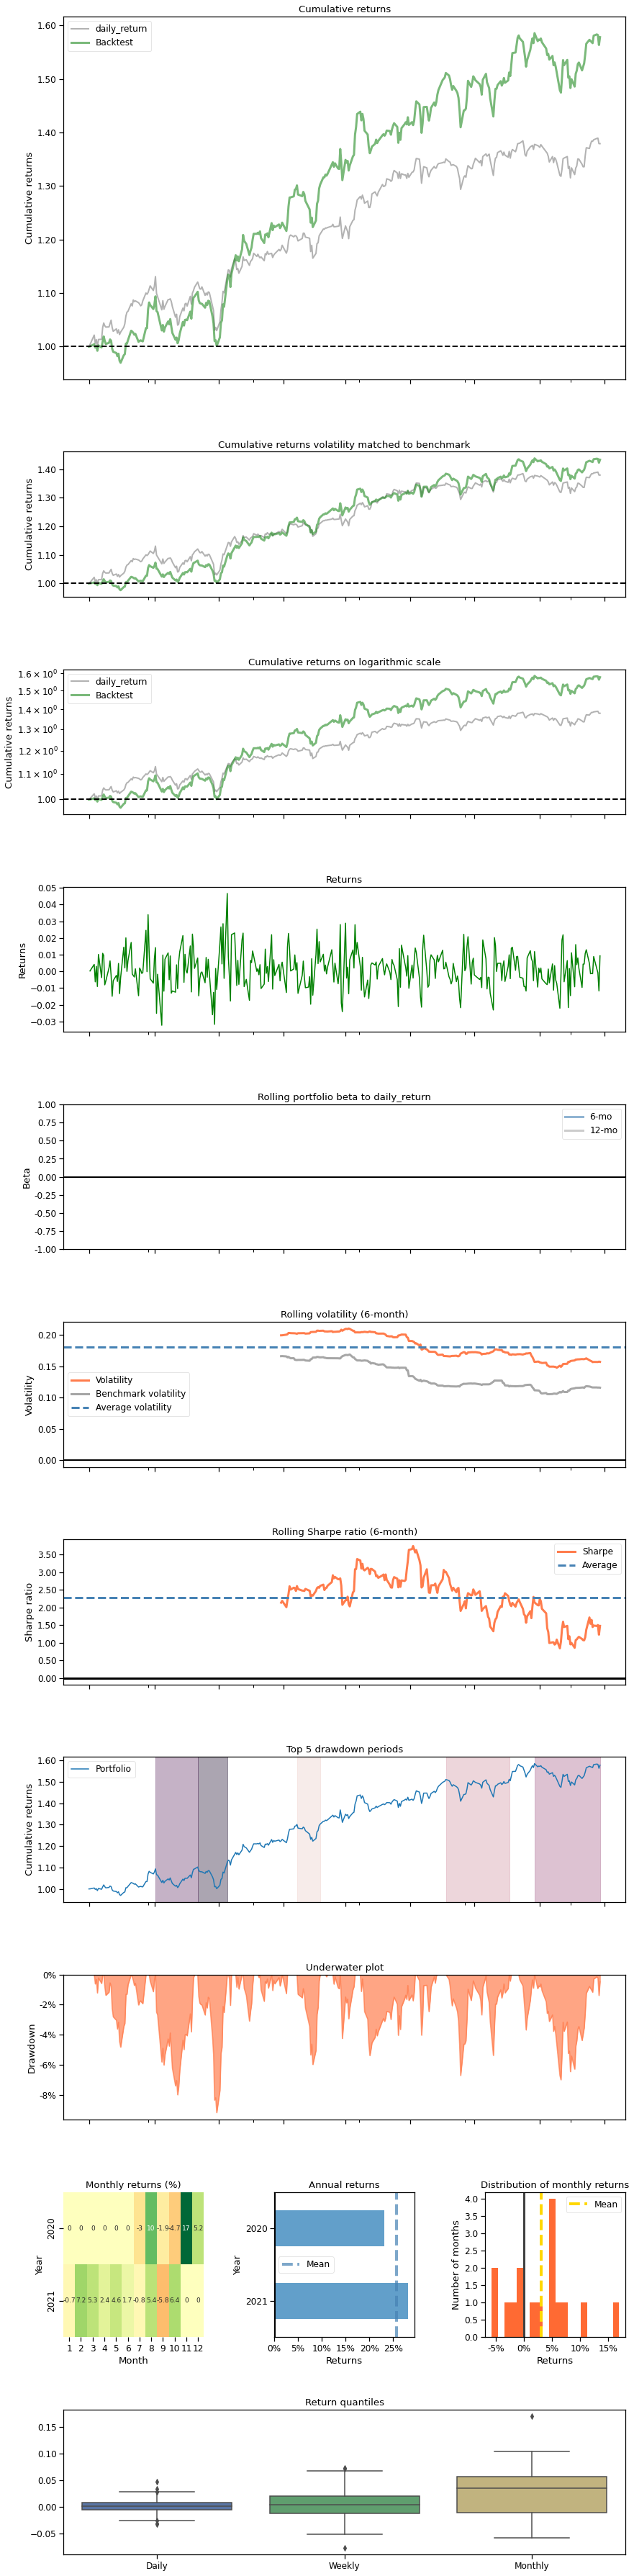

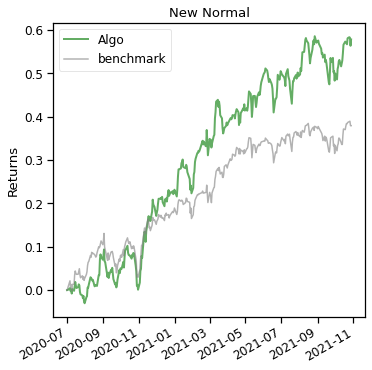

In [48]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [ ]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value2, df_actions2 = DRLAgent.DRL_prediction(
    model=trained_ppo2, 
    environment = e_trade_gym)

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value2)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'2.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value2.loc[0,'date'],
        end = df_account_value2.loc[len(df_account_value2)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value2, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value2.loc[0,'date'],
             baseline_end = df_account_value2.loc[len(df_account_value2)-1,'date'])